<a href="https://colab.research.google.com/github/bommeanusha/LSTM/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.7228 - loss: 0.6967 - val_accuracy: 0.8157 - val_loss: 0.5867
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.9093 - loss: 0.2230 - val_accuracy: 0.7912 - val_loss: 0.6777
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9335 - loss: 0.1867 - val_accuracy: 0.8730 - val_loss: 0.4539
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9313 - loss: 0.1818 - val_accuracy: 0.8429 - val_loss: 0.5928
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.9506 - loss: 0.1374 - val_accuracy: 0.8690 - val_loss: 0.6632
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9551 - loss: 0.1194 - val_accuracy: 0.8535 - val_loss: 0.6965
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.9421 - loss: 0.1592 - val_accuracy: 0.8642 - val_loss: 0.6778
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.9491 - loss: 0.1369 - val_accuracy: 0.8624 -

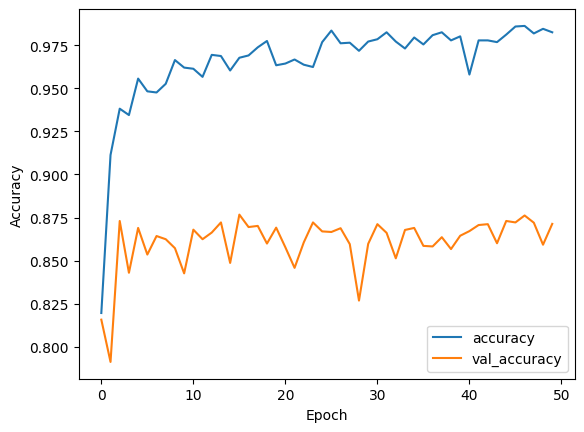

186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


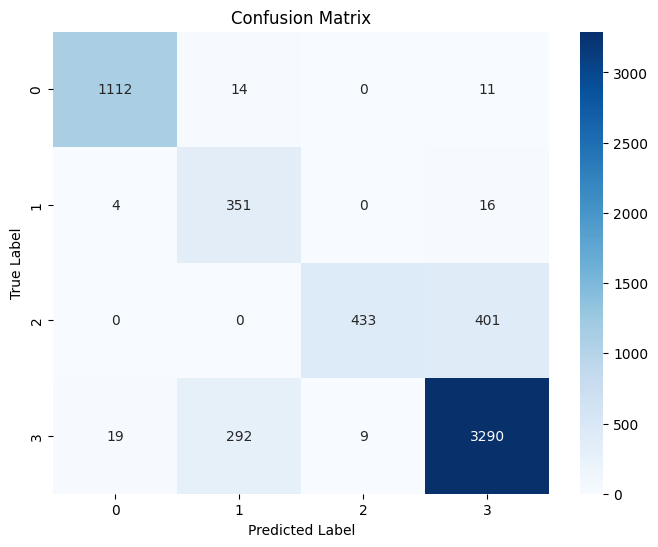

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1137
           1       0.53      0.95      0.68       371
           2       0.98      0.52      0.68       834
           3       0.88      0.91      0.90      3610

    accuracy                           0.87      5952
   macro avg       0.84      0.84      0.81      5952
weighted avg       0.89      0.87      0.87      5952



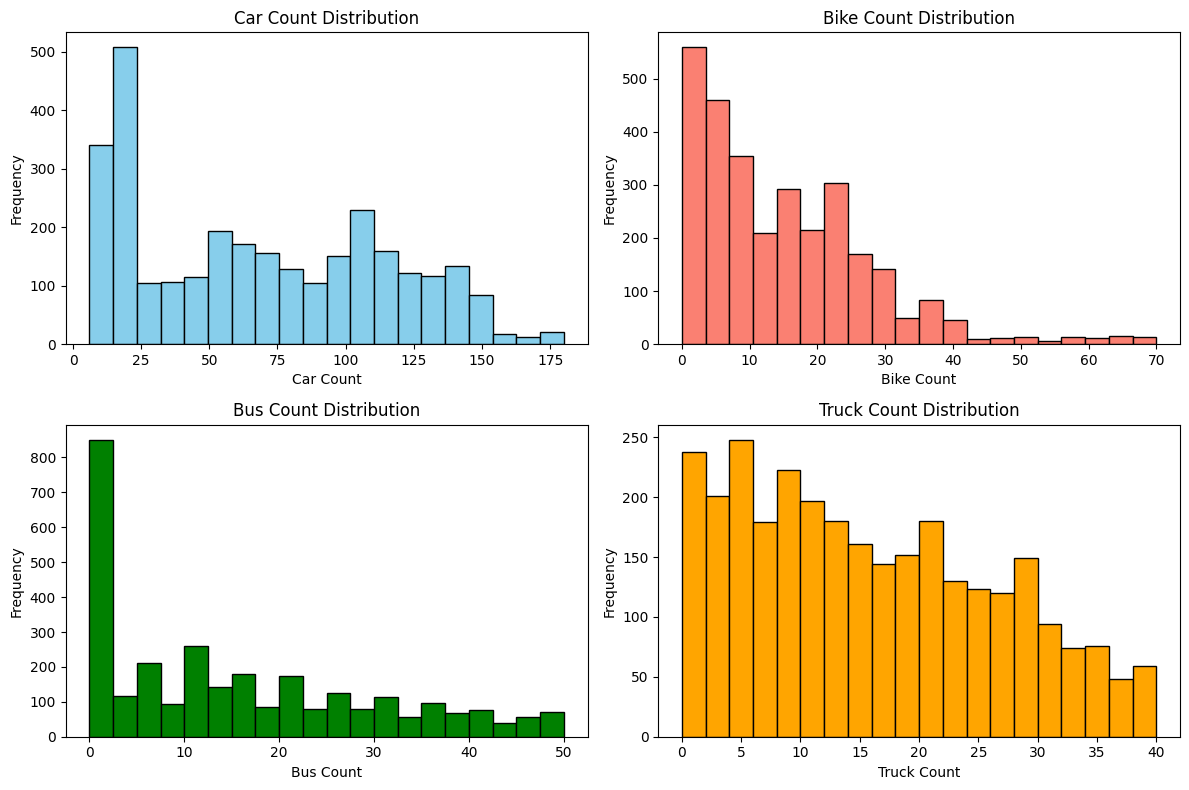

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_csv('/content/drive/MyDrive/Traffic (1).csv')
two_month = pd.read_csv('/content/drive/MyDrive/TrafficTwoMonth.csv')

# Data preprocessing
def preprocess_data(df):
    # Convert 'Date' and 'Time' columns to string data type
    df['Date'] = df['Date'].astype(str)
    df['Time'] = df['Time'].astype(str)

    # Concatenate 'Date' and 'Time' columns and convert to datetime format
    df['time_format'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d %I:%M:%S %p')

    # Sort the data by date and time
    df_sorted = df.sort_values(by=['Date', 'time_format'])

    # Encode categorical variables
    encoder_day = LabelEncoder()
    df_sorted['Day_encoded'] = encoder_day.fit_transform(df_sorted['Day of the week'])

    encoder_traffic_situation = LabelEncoder()
    df_sorted['Traffic_Situation_encoded'] = encoder_traffic_situation.fit_transform(df_sorted['Traffic Situation'])

    return df_sorted

data = preprocess_data(data)
two_month = preprocess_data(two_month)

# Select features and target
X_train = data[['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Day_encoded']]
y_train = data['Traffic_Situation_encoded']

X_test = two_month[['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Day_encoded']]
y_test = two_month['Traffic_Situation_encoded']

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Encode labels
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

# Reshape data for LSTM input (samples, timesteps, features)
sequence_length = 15
num_features = 5

# Reshape the training and testing data
def reshape_data(X):
    return X.reshape(X.shape[0], 1, X.shape[1]).repeat(sequence_length, axis=1)

X_train_reshaped = reshape_data(X_train_scaled)
X_test_reshaped = reshape_data(X_test_scaled)

# Define the LSTM model
num_classes = len(encoder.classes_)  # Get the number of unique classes

# Define the LSTM model
model = Sequential([
    LSTM(units=100, return_sequences=True, input_shape=(sequence_length, num_features)),
    Dropout(0.2),
    LSTM(units=100),
    Dense(units=num_classes, activation='softmax')  # Adjust activation function for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_reshaped, y_train_encoded, epochs=50, batch_size=32, validation_data=(X_test_reshaped, y_test_encoded))

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Prediction
y_test_pred_probs = model.predict(X_test_reshaped)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test_encoded, y_test_pred))

# Histograms of features
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.hist(data['CarCount'], bins=20, color='skyblue', edgecolor='black')
plt.title('Car Count Distribution')
plt.xlabel('Car Count')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(data['BikeCount'], bins=20, color='salmon', edgecolor='black')
plt.title('Bike Count Distribution')
plt.xlabel('Bike Count')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(data['BusCount'], bins=20, color='green', edgecolor='black')
plt.title('Bus Count Distribution')
plt.xlabel('Bus Count')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(data['TruckCount'], bins=20, color='orange', edgecolor='black')
plt.title('Truck Count Distribution')
plt.xlabel('Truck Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
